# PARTE 2: ANÁLISE EXPLORATÓRIA DOS DADOS

## Alunos: Ana Carolina Wagner e José Valentim
## Mestrado FGV-EMAp - 2018.1
## MMD - Prof. Renato

# Kaggle - TalkingData AdTracking Fraud Detection Challenge

https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection

Fraud risk is everywhere, but for companies that advertise online, click fraud can happen at an overwhelming volume, resulting in misleading click data and wasted money. Ad channels can drive up costs by simply clicking on the ad at a large scale. With over 1 billion smart mobile devices in active use every month, China is the largest mobile market in the world and therefore suffers from huge volumes of fradulent traffic.

[TalkingData](https://www.talkingdata.com), China’s largest independent big data service platform, covers over 70% of active mobile devices nationwide. They handle 3 billion clicks per day, of which 90% are potentially fraudulent. Their current approach to prevent click fraud for app developers is to measure the journey of a user’s click across their portfolio, and flag IP addresses who produce lots of clicks, but never end up installing apps. With this information, they've built an IP blacklist and device blacklist.

While successful, they want to always be one step ahead of fraudsters and have turned to the Kaggle community for help in further developing their solution. In their 2nd competition with Kaggle, you’re challenged to build an algorithm that predicts whether a user will download an app after clicking a mobile app ad. To support your modeling, they have provided a generous dataset covering approximately 200 million clicks over 4 days!

___
### File descriptions

* `train.csv` - the training set
* `train_sample.csv` - 100,000 randomly-selected rows of training data, to inspect data before downloading full set
* `test.csv` - the test set
* `sampleSubmission.csv` - a sample submission file in the correct format
* `UPDATE: test_supplement.csv` - This is a larger test set that was unintentionally released at the start of the competition. It is not necessary to use this data, but it is permitted to do so. The official test data is a subset of this data.
___

### Data fields

Each row of the **training data** contains a click record, with the following features.

* `ip`: ip address of click.
* `app`: app id for marketing.
* `device`: device type id of user mobile phone (e.g., iphone 6 plus, iphone 7, huawei mate 7, etc.)
* `os`: os version id of user mobile phone
* `channel`: channel id of mobile ad publisher
* `click_time`: timestamp of click (UTC)
* `attributed_time`: if user download the app for after clicking an ad, this is the time of the app download
* `is_attributed`: the target that is to be predicted, indicating the app was downloaded

Note that ip, app, device, os, and channel are encoded.

The **test data** is similar, with the following differences:

* `click_id`: reference for making predictions
* `is_attributed`: not included

## Considerações

* Trata-se de um problema de **classificação binária** - ou seja, nossa variável alvo é um atributo binário (o usuário está tornando o clique fraudulento ou não?);


* O objetivo é classificar os usuários em "fraudulentos" ou "não fraudulentos". Ou ainda, estamos tentando prever downloads após cliques ou não.


* Para a EDA, não usaremos o conjunto completo de treinamento, mas sim um subconjunto. Optamos por trabalhar com **10% do conjunto de treinamento**. A parte do processamento dos dados encontra-se no notebook `1_Processamento_dos_Dados`.
____

## 1. Carregando bibliotecas

In [1]:
import pandas as pd
import dask.dataframe as dd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.plotly as py
import plotly.offline as pyo
import plotly.figure_factory as ff
import plotly.graph_objs as go
%matplotlib inline

# Configuração geral dos plots
sns.set(font_scale=1.2)
pal = sns.color_palette()
sns.set(color_codes=True)
sns.set_style('darkgrid')
#pd.set_option('display.float_format', lambda x: '%.3f' % x)

import os
import csv
import time
import datetime
import gc # garbage collection 

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

path = os.getcwd()

## 2. Importando os dados

In [2]:
# Data Types - reduzir o espaço de armazenamento usando inteiros onde possível
dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'day'           : 'uint8',
        'hour'          : 'uint8',
        'minute'        : 'uint8',
        'second'        : 'uint8'
        }

In [3]:
# Importando Apenas As Colunas Selecionadas
train_cols = ['ip', 'app', 'device', 'os', 'channel', 'day', 'hour','is_attributed']
test_cols  = ['ip', 'app', 'device', 'os', 'channel', 'day', 'hour']

In [54]:
df_train = pd.read_csv(path + "/datasets/train_sample_10_reduced.csv", dtype=dtypes, usecols = train_cols)
df_test = pd.read_csv(path + "/datasets/test_reduced.csv", dtype=dtypes, usecols = test_cols)

In [5]:
df_train.head()

,ip,app,device,os,channel,day,hour,is_attributed
0,35810,3,1,13,379,6,14,0
1,165970,3,1,13,379,6,14,0
2,111385,3,1,18,379,6,14,0
3,74715,3,1,19,379,6,14,0
4,148454,3,1,19,379,6,14,0


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18488323 entries, 0 to 18488322
Data columns (total 8 columns):
ip               uint32
app              uint16
device           uint16
os               uint16
channel          uint16
day              uint8
hour             uint8
is_attributed    uint8
dtypes: uint16(4), uint32(1), uint8(3)
memory usage: 264.5 MB


* As *features* **ip**, **app**, **device** , **os** e **chanel** são na verdade variáveis categóricas codificadas como inteiros. 

## 3. Os dados estão balanceados?

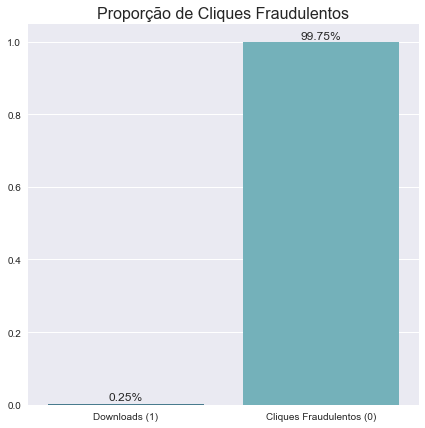

In [7]:
attributed_train = (df_train['is_attributed'].value_counts()/len(df_train['is_attributed']))

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(1,1,1)
sns.barplot(['Downloads (1)', 'Cliques Fraudulentos (0)'], [attributed_train[1],attributed_train[0]], palette='GnBu_d')
ax.set_title('Proporção de Cliques Fraudulentos')
ax.title.set_size(16)
for p, uniq in zip(ax.patches,[attributed_train[1],attributed_train[0]]):
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height+0.01, '{}%'.format(round(uniq * 100, 2)), ha="center")

Como podemos observar, há uma grande suspeita de que ocorram muitas fraudes no conjunto de treinamento. Como existe uma grande desproporção entre o número de exemplos de cada classe, podemos concluir que os **dados estão desbalanceados**. 

A presença de classes desbalanceados pode tornar o problema bem mais difícil, podendo ser um desafio para avaliarmos futuramente o desempenho dos classficadores. Essa situação frequentemente faz com os exemplos da classe minoritária sejam classificados incorretamente. Isso será abordado melhor na próxima etapa do trabalho. 

## 4. Valores únicos

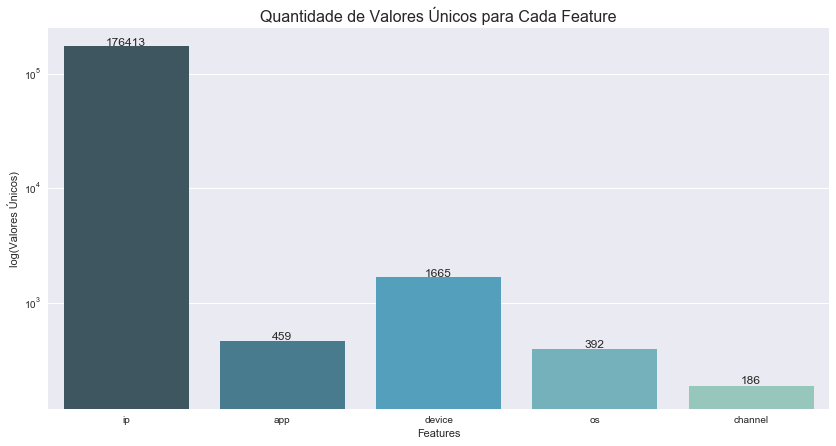

In [8]:
plt.figure(figsize=(14, 7))
uniques = [len(df_train[col].unique()) for col in train_cols[:-3]]
ax = sns.barplot(train_cols[:-3], uniques, log=True, palette="GnBu_d")
ax.set(xlabel='Features', ylabel='log(Valores Únicos)', title='Quantidade de Valores Únicos para Cada Feature')
ax.title.set_size(16)
for p, uniq in zip(ax.patches, uniques):
    ax.text(p.get_x()+p.get_width()/2., p.get_height() + 10, uniq, ha="center") 

Podemos observar que:

* A quantidade de valores únicos de cada *feature* é pequeno em relação ao dimensionamento do conjunto de dados (treinamento). Estamos analisando mais de 18,5 milhões de entradas e só temos aproximadamente 176 mil IPs.


* A quantidade de IPs distintos é bem maior do que a das demais *features*.

## 5. Quais os valores mais frequentes de cada *feature*?

In [336]:
def plot_top_featutes(list_features, fig_size = (16, 28), k_round_downloads=2): 

    plt.figure(figsize=fig_size)

    i = 1
    m = len(list_features)
    
    for col in list_features:
        counts = pd.value_counts(df_train[col].values, ascending=False)[0:10]
        indx = counts.index
        counts.reset_index(drop=True, inplace=True)

        plt.subplot(m,2,i)
        ax = sns.barplot(counts.index, counts.values, log=True, palette="GnBu_d")
        ax.set_xticklabels(indx)
        ax.set_xlabel('ID do ' +  str(col) + '\n')
        ax.set_ylabel("log(Quantidade)")
        ax.set_title("Valores Mais Frequentes de " + str(col) + ' - Cliques')

        for p, vals in zip(ax.patches, [round(100*val/len(df_train),2) for val in counts.values]):
            ax.text(p.get_x() + p.get_width()/2., p.get_height() + 10, '{}%'.format(vals), ha="center") 

        counts_downloads = pd.value_counts(df_train[df_train.is_attributed == 1][col].values, ascending=False)[0:10]
        indx_downloads = counts_downloads.index
        counts_downloads.reset_index(drop=True, inplace=True)

        plt.subplot(m,2,i+1)
        ax = sns.barplot(counts_downloads.index, counts_downloads.values, log=True, palette="GnBu_d")
        ax.set_xticklabels(indx_downloads)
        ax.set_xlabel('ID do ' +  str(col) + '\n ' )
        ax.set_ylabel("log(Quantidade)")
        ax.set_title("Valores Mais Frequentes de " + str(col) + ' - Downloads')

        i = i + 2

        for p, vals in zip(ax.patches, [round(100*val/len(df_train),k_round_downloads) for val in counts_downloads.values]):
            ax.text(p.get_x() + p.get_width()/2., p.get_height() + 10, '{}%'.format(vals), ha="center") 
            

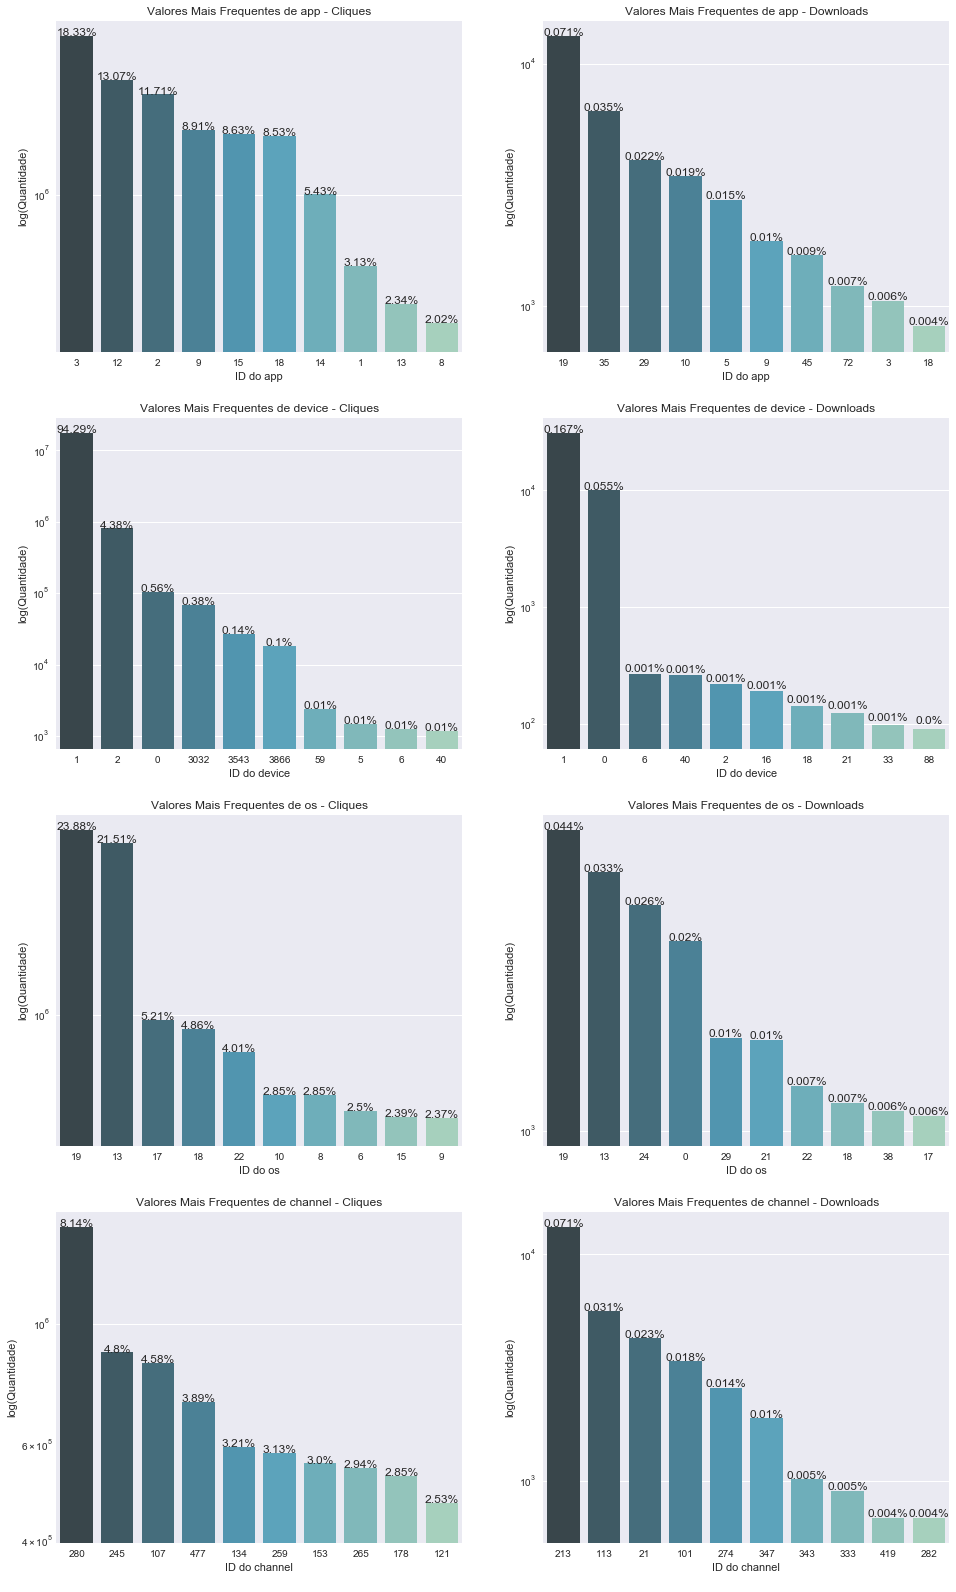

In [346]:
plot_top_featutes(train_cols[1:-3], k_round_downloads=3)

* Temos grandes produtores de aplicativos (**app**). Os cinco maiores correspondem a mais do que 50% do mercado analisado. 


* Podemos percber claramente que existem dois grandes tipos de dispositivos (**device**). O mesmo ocorre com o sistema operacional (**os**), provavelmente devem corresponder ao IOS e Android.

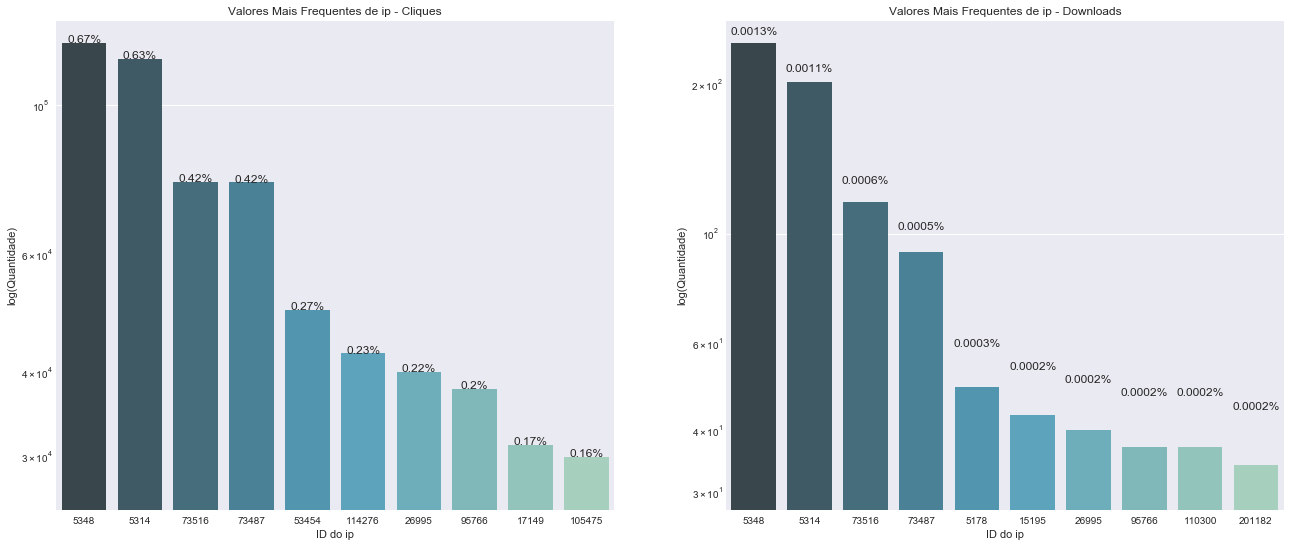

In [345]:
plot_top_featutes(['ip'], (22, 9), k_round_downloads=4)

In [324]:
counts_ips_clicks = pd.value_counts(df_train['ip'].values, ascending=False)[0:10]
counts_ips_clicks.values

array([123746, 117181,  76897,  76845,  49603,  42762,  40180,  37862,
        31290,  29958])

In [326]:
counts_ips_downloads = pd.value_counts(df_train[df_train.is_attributed == 1]['ip'].values, ascending=False)[0:10]
counts_ips_downloads.values

array([243, 203, 116,  92,  49,  43,  40,  37,  37,  34])

* Nem todos os 10 IPs que geram mais cliques correspondem aos maiores geradores de downloads.  


* O IP '5348', por exemplo, dos mais de 123 mil cliques realizados em uma janela de quatro dias só efetua de fato 243 downloads. Isso é bem suspeito!!!

* Podemos observar pelo gráfico que existem IPs que geram uma grande quantidade de cliques nos anúncios. Mas será que o IP codificado corresponde ao ID de um dispositivo ou é o ID da rede? Ou seja, será que o fato de termos IPs que acionam um clique mais de 40 mil vezes (alguns mais de 100 mil) não pode ser justificado em parte por ser alguma rede que hospede um grupo de usuários? Mas ainda assim esse valor não seria elevado demais, visto que os cliques computados abrangem uma escala de quatro das? Vamos explorar melhor isso!!!

## 6. Matriz de correlação 

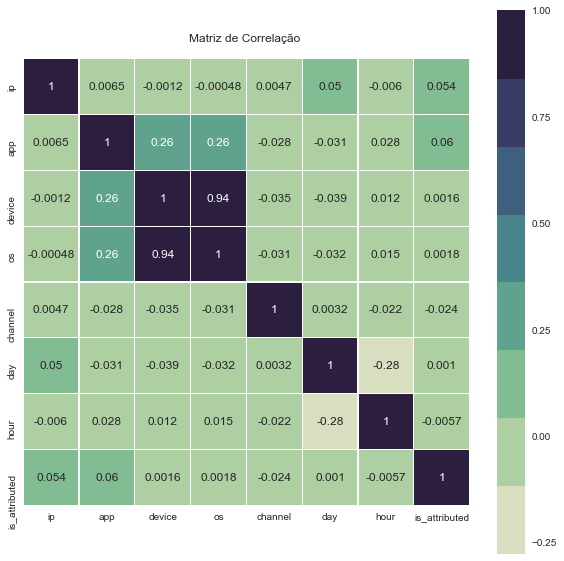

In [11]:
colormap = sns.cubehelix_palette(8, start=.5, rot=-.75)
plt.figure(figsize=(10,10))
plt.title('Matriz de Correlação \n')
sns.heatmap(df_train.corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

Pela matriz de correlação, podemos observar que:


* Como era de se esperar o **device** e o **os** estão correlacionados positivamente. Ou ainda, são as variáveis que estão mais correlacionadas.


* Ambas as variáveis **device** e **os** possuem a mesma correlação positiva com a variável **app**. Isso se deve ao fato que existem muitos aplicativos que são exclusivos de um tipo de sistema operacional, que por sua vez é dependente do aparelho utilizado. 


* Apesar do  **ip** e o **app** serem os que mais influenciam a variável alvo, a correlação positiva é bem baixa (bem próxima de zero).


* Podemos dizer que também existe uma pequena correlação positiva entre o **ip** e o **dia**.

## 7. Análise temporal dos cliques

In [12]:
def get_dayHour_data(is_attributed, click):
    temp = df_train.groupby(["day","hour"]).apply(lambda x: len(x[x.is_attributed == is_attributed]))
    days = temp.index.get_level_values("day")
    hours = temp.index.get_level_values("hour")
    
    dayHour = []
    for day, hour in zip(days, hours):
        
        dayHour.append(" - ".join([str(day)+'/11/2017',str(hour) + 'H']))
    
    return pd.DataFrame({"dayHour":dayHour, click:temp.values}, index=np.arange(len(dayHour)))

In [110]:
downloads = df_train.groupby("hour").apply(lambda x: len(x[x.is_attributed == 1]))
clicks = df_train.groupby("hour").apply(lambda x: len(x[x.is_attributed == 0]))

In [57]:
clickDownload = get_dayHour_data(0,"clicks").merge(get_dayHour_data(1,"downloads"), how="outer", on="dayHour")

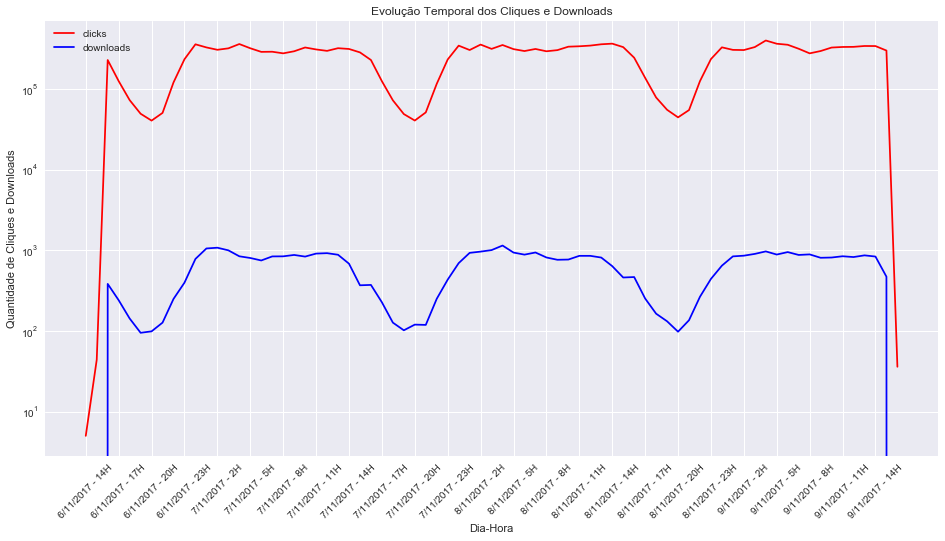

In [87]:
plt.figure(figsize=(16,8))

plt.plot(range(len(clickDownload)), clickDownload.clicks, color='red')
plt.plot(range(len(clickDownload)), clickDownload.downloads, color='blue')
plt.yscale("log")
plt.legend()

indx = [i for i in range(0, len(clickDownload), 3)]
plt.xticks([i for i in range(0, len(clickDownload), 3)], 
           clickDownload.dayHour.values[indx],
            rotation=45)

plt.xlabel("Dia-Hora")
plt.ylabel("Quantidade de Cliques e Downloads")
plt.title("Evolução Temporal dos Cliques e Downloads")

* O comportamento dos usuários tende a ser consistente ao longo dos dias, podemos perceber uma certa tendência. 


* Os cliques no conjunto de treinamento duram 4 dias (6/11/2017 (seguda-feira) a 10/11/2017 (quinta-feira)).


* No dia 6/11/2017 foram analisados poucos dados (começaram a partir das 14h), por isso que pode parecer que foram realizados menos cliques e consequentemente menos downloads. 


* A quantidade de cliques convertidos em downloads é de fato bem baixa. 

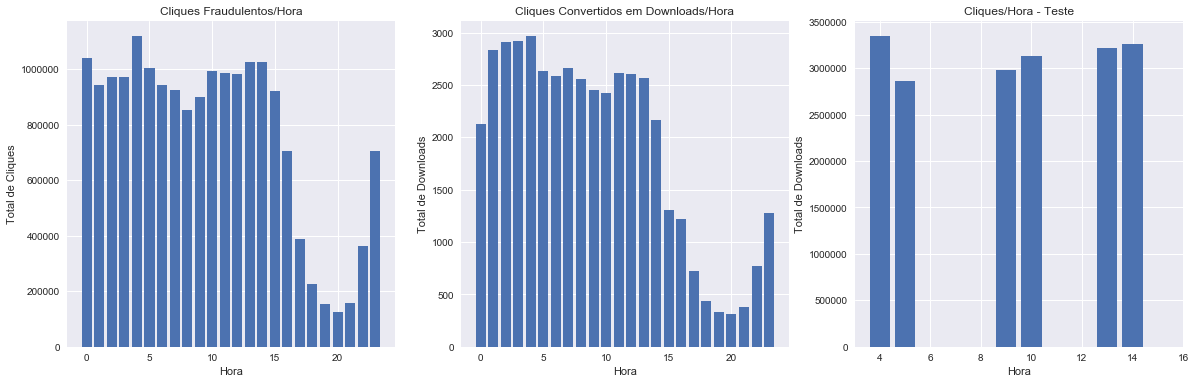

In [113]:
plt.figure(figsize=(20,6))

plt.subplot(1,3,1)
plt.bar(clicks.index, clicks.values)
plt.xlabel("Hora")
plt.ylabel("Total de Cliques")
plt.title("Cliques Fraudulentos/Hora")

plt.subplot(1,3,2)
plt.bar(downloads.index, downloads.values)
plt.xlabel("Hora")
plt.ylabel("Total de Downloads")
plt.title("Cliques Convertidos em Downloads/Hora")

clicks_test = df_test['hour'].value_counts(sort = False)
plt.subplot(1,3,3)
plt.bar(clicks_test.index, clicks_test.values)
plt.xlabel("Hora")
plt.ylabel("Total de Downloads")
plt.title("Cliques/Hora - Teste")

In [90]:
clicks_test

4     3344125
5     2858427
6         381
9     2984808
10    3127993
11        413
13    3212566
14    3261257
15        499
Name: hour, dtype: int64

* Podemos perceber que a maior parte dos cliques ocorre de madrugada até o início da tarde, começando a ter uma evidente queda a partir das 15h. 


* A quantidade de cliques volta a aumentar a partir das 21h. 


* Os cliques do do conjunto teste são todos do dia 11/11/2017 (sexta-feira) - isso já foi analisado no notebook anterior. Além disso, eles não estão tão bem destribuídos ao longo do dia como no conjunto de treinamento. Os dados analisados compreendem apenas 9 horas, sendo que 6 delas apresentam uma concentração bem expressiva. Nos horários de 6h, 11h e 15h os dados possuem uma concentração bem baixa (não conseguimos visualizá-los no gráfico da direita). 

## 8. Taxa de conversão dos cliques

### 8.1. Qual a relação entre os IPs e os cliques?

In [104]:
clicks = df_train[['ip', 'is_attributed']].groupby('ip', as_index=False).count().sort_values('is_attributed', ascending=False)
proportion = df_train[['ip', 'is_attributed']].groupby('ip', as_index=False).mean().sort_values('is_attributed', ascending=False)

tx_clicks_ip = clicks.merge(proportion, on='ip', how='left')
tx_clicks_ip.columns = ['ip', 'clicks', 'proportion']

tx_clicks_ip['downloads'] = tx_clicks_ip['clicks']*tx_clicks_ip['proportion']

tx_clicks_ip.head()

,ip,clicks,proportion,downloads
0,5348,123746,0.001964,243.0
1,5314,117181,0.001732,203.0
2,73516,76897,0.001509,116.0
3,73487,76845,0.001197,92.0
4,53454,49603,0.000323,16.0


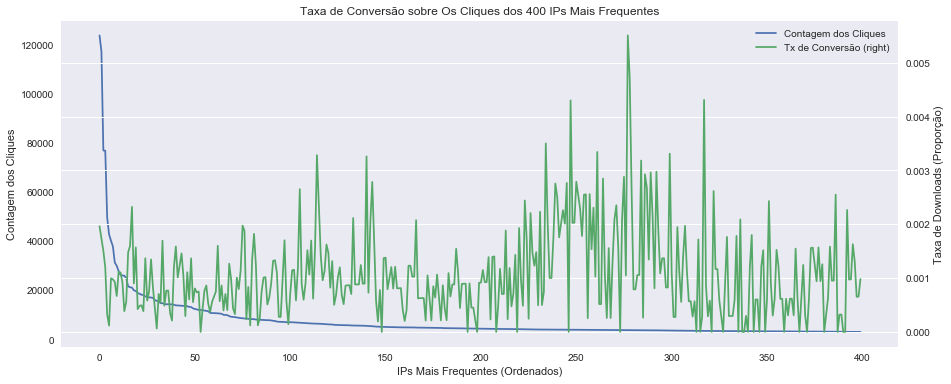

In [153]:
n_ip = 400 # quantidade de IPs mais frequentes
ax1 = tx_clicks_ip.clicks[:n_ip].plot(figsize=(15,6), legend = True, label='Contagem dos Cliques')
ax1.set(xlabel = 'IPs Mais Frequentes (Ordenados)', ylabel = 'Contagem dos Cliques')

ax2 = tx_clicks_ip.proportion[:n_ip].plot(secondary_y = True, legend = True, label='Tx de Conversão')
ax2.set(ylabel = 'Taxa de Downloads (Proporção)')

plt.title('Taxa de Conversão sobre Os Cliques dos ' + str(n_ip) +  ' IPs Mais Frequentes')
plt.show()

* Na análse de valores únicos feita anteriormente, observamos que um pouco mais de 170 mil IPs são responsáveis por todos os cliques gerados. 


* Alguns IPs são responsáveis por uma boa parte dos cliques. No entanto, isso não significa que esses cliques foram convertidos em downloads de fato. 


* A quantidade downloads é maior para os IPs não tão frequentes. Podemos perceber alguns picos próximo do 300º IP mais frequente. 


* Parece haver uma relação inversa entre a taxa de conversão e o número de cliques.

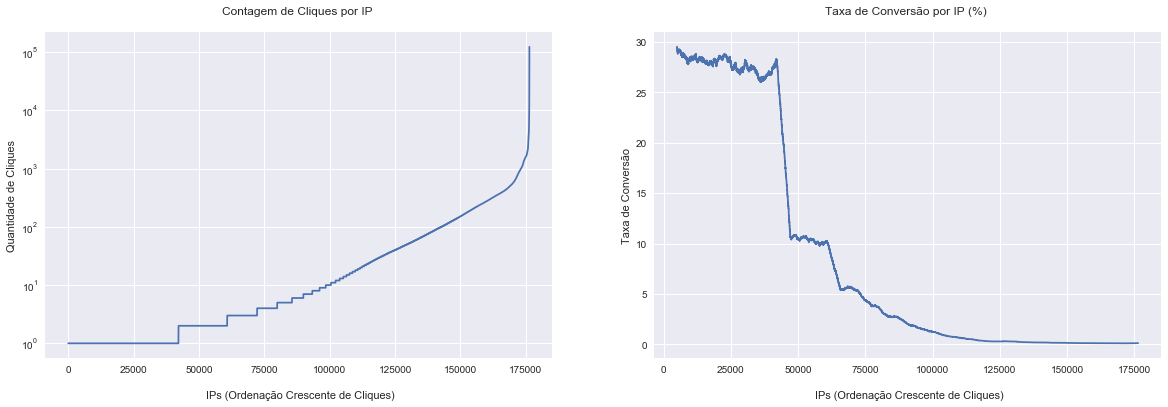

In [195]:
ip_agg = df_train.groupby(['ip']).agg({'is_attributed': ['count'], 'ip': ['count'] })
ip_agg['is_attributed'] = df_train.groupby("ip").apply(lambda x: len(x[x.is_attributed == 1]))
ip_agg['rate_conversion'] = (100*ip_agg['is_attributed']/ip_agg['ip']).round(3)
ip_agg = ip_agg.sort_values(by=[('ip', 'count')], ascending=True)
ip_agg_sort = np.array(ip_agg[('ip','count')])

fig = plt.figure(figsize=(20,6))
ax = fig.add_subplot(1, 2, 1)
ax.set(title='Contagem de Cliques por IP \n')
ax.set(xlabel = '\n IPs (Ordenação Crescente de Cliques)', ylabel = 'Quantidade de Cliques')
line = ax.plot(ip_agg_sort)
ax.set_yscale('log')

ip_rolling_conversion = np.array(pd.rolling_mean(ip_agg['rate_conversion'], window=5000))
ax = fig.add_subplot(1, 2, 2)
ax.set(title='Taxa de Conversão por IP (%) \n')
ax.set(xlabel = '\n IPs (Ordenação Crescente de Cliques)', ylabel = 'Taxa de Conversão')
line = ax.plot(ip_rolling_conversion)

* De fato a quantidade de cliques parece ser inversamente proporcional a taxa de conversão. Os IPs que são responsáveis pelas maiores quantidades de cliques são os mesmos que possuem uma baixa (quase nula) taxa de conversão.


* Há um reforço na teoria de que ou o IP corresponde a uma rede ou realmente existe uma fraude. 


* Apesar de podermos perceber a presença de um padrão entre o **IP** e a taxa de conversão, como existem muitos IPs diferentes e no conjunto de dados teste também existem muitos outros novos IPs, temos que ter bastante cautela para utilizar o Ip como forma de aumentar o escore da predição. 

### 8.2 Qual a relação entre os APPs e os cliques?

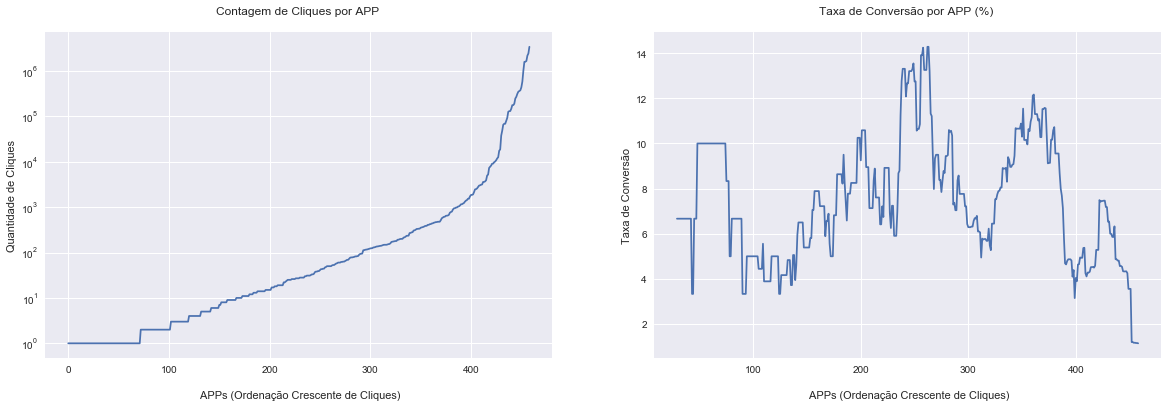

In [206]:
app_agg = df_train.groupby(['app']).agg({'is_attributed': ['count'], 'app': ['count'] })
app_agg['is_attributed'] = df_train.groupby("app").apply(lambda x: len(x[x.is_attributed == 1]))
app_agg['rate_conversion'] = (100*app_agg['is_attributed']/app_agg['app']).round(3)
app_agg = app_agg.sort_values(by=[('app', 'count')], ascending=True)
app_agg_sort = np.array(app_agg[('app','count')])

fig = plt.figure(figsize=(20,6))
ax = fig.add_subplot(1, 2, 1)
ax.set(title='Contagem de Cliques por APP \n')
ax.set(xlabel = '\n APPs (Ordenação Crescente de Cliques)', ylabel = 'Quantidade de Cliques')
line = ax.plot(app_agg_sort)
ax.set_yscale('log')

app_rolling_conversion = np.array(pd.rolling_mean(app_agg['rate_conversion'], window=30))
ax = fig.add_subplot(1, 2, 2)
ax.set(title='Taxa de Conversão por APP (%) \n')
ax.set(xlabel = '\n APPs (Ordenação Crescente de Cliques)', ylabel = 'Taxa de Conversão')
line = ax.plot(app_rolling_conversion)

* Podemos observar que os aplicativos com maior frequência de cliques não são responsáveis pelas maiores taxas de conversão. A taxa de conversão do aplicativo responsável pela maioria dos cliques é muito baixa.


* A frequência de aplicativo é mais balanceada do que a frequência de IP. Ao contrário do IP, temos mais campos com esses mesmos IDs de aplicativo no conjunto de dados teste. 

### 8.2 Qual a relação entre as demais *features* e os cliques?

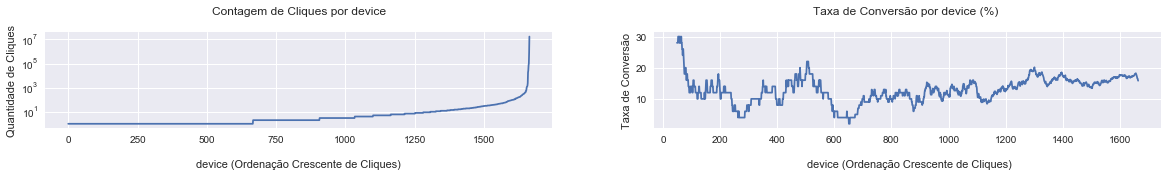

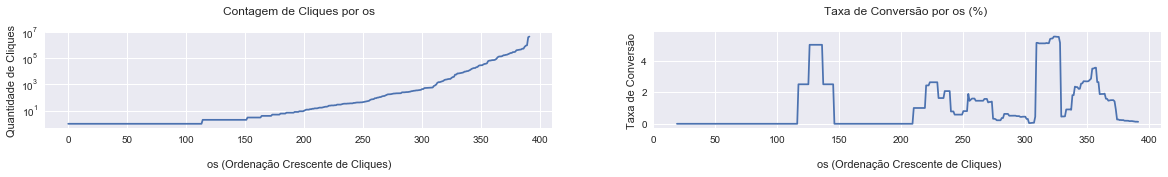

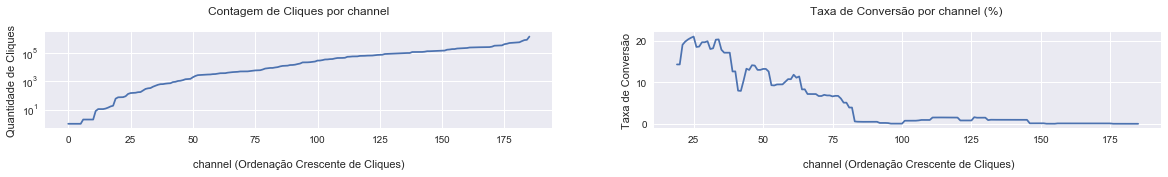

In [235]:
i = 1
j = 0
w = [50, 20, 20]
for cat in ['device', 'os', 'channel']:
    agg = df_train.groupby([cat]).agg({'is_attributed': ['count'], cat: ['count'] })
    agg['is_attributed'] = df_train.groupby(cat).apply(lambda x: len(x[x.is_attributed == 1]))
    agg['rate_conversion'] = (100*agg['is_attributed']/agg[cat]).round(3)
    agg = agg.sort_values(by=[(cat, 'count')], ascending=True)
    agg_sort = np.array(agg[(cat,'count')])
    
    fig = plt.figure(figsize=(20,6))
    ax = fig.add_subplot(3, 2, i)
    ax.set(title='Contagem de Cliques por ' + cat +'\n')
    ax.set(xlabel = '\n' + cat + ' (Ordenação Crescente de Cliques)', ylabel = 'Quantidade de Cliques')
    line = ax.plot(agg_sort)
    ax.set_yscale('log')

    rolling_conversion = np.array(pd.rolling_mean(agg['rate_conversion'], window=w[j]))
    ax = fig.add_subplot(3, 2, i+1)
    ax.set(title='Taxa de Conversão por ' + cat + ' (%) \n')
    ax.set(xlabel = '\n ' + cat + ' (Ordenação Crescente de Cliques)', ylabel = 'Taxa de Conversão')
    line = ax.plot(rolling_conversion)
    
    i = i + 2
    j = j + 1

* Podemos observar que a maioria dos cliques é concentrada em um dispositivo. Ou seja, existe um dispositivo que claramente é o principal. 


* Os dispositivos são desproporcionalmente destribuídos. 


* Parece que a taxa de conversão diminui para o sistema operacional com maiores frequência de cliques. 


* A frequência de cliques classificadas por canal é a que sofre menos distorção. 


* A taxa de conversão diminui para o canal mais comum. A taxa de conversão do canal mais procurado é bastante baixa.


## 9. Analisando o ip mais frequente

In [637]:
ip_downloads = pd.value_counts(df_train[df_train.is_attributed == 1]['ip'].values, ascending=False)[0:10]
ip_clicks = pd.value_counts(df_train['ip'].values, ascending=False)[0:10]

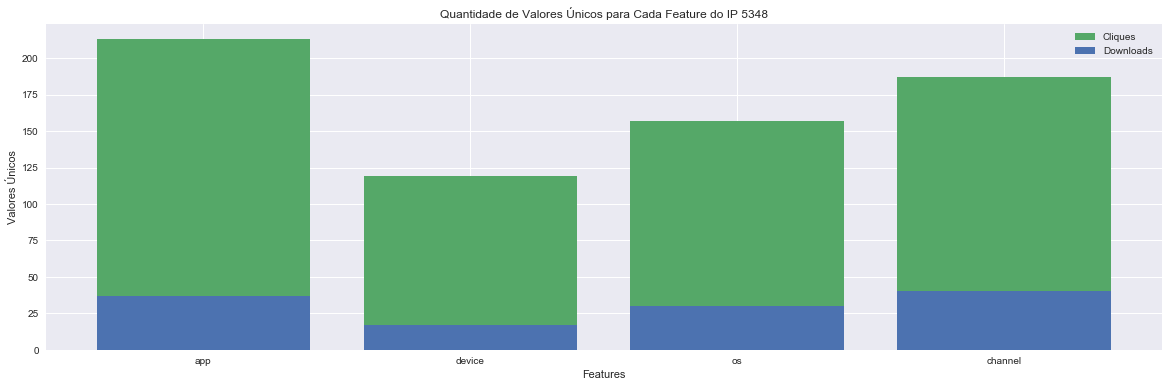

In [638]:
plt.figure(figsize=(20,6))

ip = list(ip_clicks.index)[0]

xt = df_train[df_train.ip == ip]
uniquest = [len(xt[col].unique()) for col in train_cols[1:-3]]

x1 = df_train[(df_train.ip == ip) & (df_train.is_attributed == 1)]
uniques1 = [len(x1[col].unique()) for col in train_cols[1:-3]]

N = len(train_cols[1:-3])
ind = np.arange(N)

p1 = plt.bar(ind, uniques1)
p2 = plt.bar(ind, uniquest, bottom=uniques1)

plt.ylabel('Valores Únicos')
plt.xlabel('Features')
plt.title('Quantidade de Valores Únicos para Cada Feature do IP ' + str(ip))
plt.xticks(ind, train_cols[1:-3])
plt.legend((p2[0], p1[0]), ('Cliques', 'Downloads'))

plt.show()

In [639]:
print('Quantidade de Valores Únicos para os Cliques do IP '+ str(ip) + ': ' +str(uniquest))

Quantidade de Valores Únicos para os Cliques do IP 5348: [176, 102, 127, 147]


In [640]:
print('Quantidade de Valores Únicos para os Downloads do IP '+ str(ip) + ': ' +str(uniques1))

Quantidade de Valores Únicos para os Downloads do IP 5348: [37, 17, 30, 40]


In [647]:
df_train2 = pd.read_csv(path + "/datasets/train_sample_10_reduced.csv", dtype=dtypes, index_col=0)
df_train2[(df_train2.ip == ip) & (df_train2.day == 7) & (df_train2.hour == 13)][:20]

,ip,app,device,os,channel,day,hour,minute,second,is_attributed
5044981,5348,2,1,3,219,7,13,0,0,0
5045079,5348,12,1,15,178,7,13,0,1,0
5045234,5348,15,1,13,480,7,13,0,3,0
5045255,5348,14,2,10,123,7,13,0,3,0
5045424,5348,18,1,13,121,7,13,0,5,0
5045453,5348,21,2,13,128,7,13,0,5,0
5045576,5348,9,1,18,442,7,13,0,6,0
5045681,5348,12,1,6,178,7,13,0,7,0
5045710,5348,6,1,19,125,7,13,0,8,0
5045723,5348,9,1,19,442,7,13,0,8,0


* Talvez o IP 5348 que tenha maior frequência de cliques esteja realmente relacionado a uma rede, afinal os cliques são feitos a partir de diferentes canais para diversos aplicativos de diferentes aparelhos e sistemas.


* Além disso, o mesmo IP realizou vários cliques no mesmo momento para aplicativos distintos de aparelhos diferentes. 

## 10. Analisando os cliques sem downloads de cada *feature*

In [630]:
def plot_top_featutes_clicks(list_features, fig_size = (16, 10), k_round_downloads=2): 

    plt.figure(figsize=fig_size)

    i = 1
    
    for col in list_features:
        counts_clicks = pd.value_counts(df_train[df_train.is_attributed == 0][col].values, ascending=False)[0:10]
        indx_clicks = counts_clicks.index
        counts_clicks.reset_index(drop=True, inplace=True)

        plt.subplot(2,2,i)
        ax = sns.barplot(counts_clicks.index, counts_clicks.values, log=True, palette="GnBu_d")
        ax.set_xticklabels(indx_clicks)
        ax.set_xlabel('ID do ' +  str(col) + '\n ' )
        ax.set_ylabel("log(Quantidade)")
        ax.set_title("Valores Mais Frequentes de " + str(col) + ' - Cliques Fraudulentos')

        i = i + 1

        for p, vals in zip(ax.patches, [round(100*val/len(df_train),k_round_downloads) for val in counts_downloads.values]):
            ax.text(p.get_x() + p.get_width()/2., p.get_height() + 10, '{}%'.format(vals), ha="center") 
            

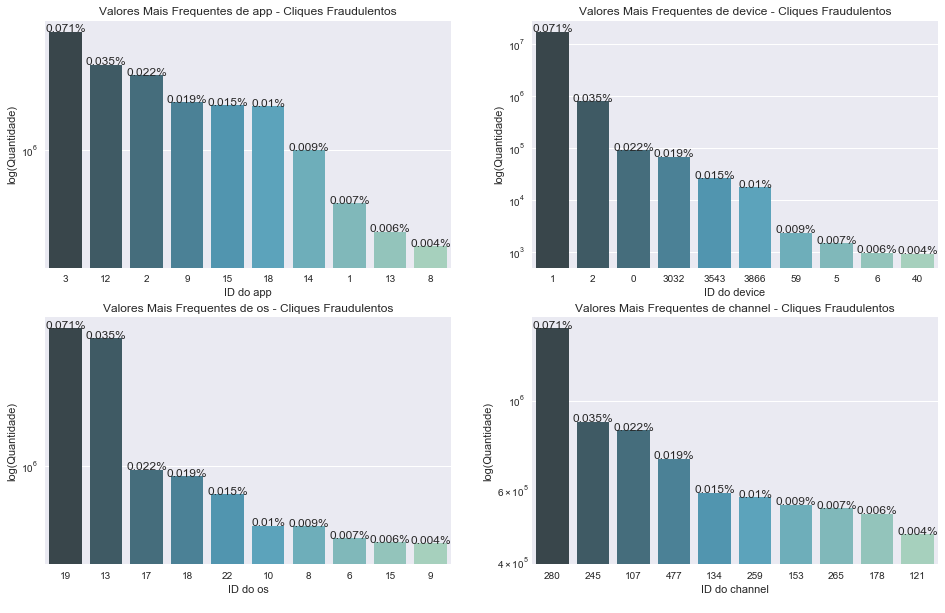

In [631]:
plot_top_featutes_clicks(train_cols[1:-3], k_round_downloads=3)

In [709]:
app = [3, 12]
channel = [280, 245]
os = [19, 13]
device = [1,2]

In [710]:
print('Aplicativos e Aparelhos Mais Frequentes')

total = len(df_train[(df_train.app == app[0]) & (df_train.is_attributed == 0)])
x = len(df_train[(df_train.app == app[0]) & (df_train.is_attributed == 0) & (df_train.device == device[0])])
print('Proporção de cliques "falsos" feitos no aplicativo ' + str(app[0]) + ' provenientes do aparelho ' + str(device[0]) + ': ' + str(round(100*x/total,2)) + '%')
y = len(df_train[(df_train.app == app[0]) & (df_train.is_attributed == 0) & (df_train.device == device[1])])
print('Proporção de cliques "falsos" feitos no aplicativo ' + str(app[0]) + ' provenientes do aparelho ' + str(device[1]) + ': ' + str(round(100*y/total,2)) + '%')
print('\n')
total = len(df_train[(df_train.app == app[1]) & (df_train.is_attributed == 0)])
x = len(df_train[(df_train.app == app[1]) & (df_train.is_attributed == 0) & (df_train.device == device[0])])
print('Proporção de cliques "falsos" feitos no aplicativo ' + str(app[1]) + ' provenientes do aparelho ' + str(device[0]) + ': ' + str(round(100*x/total,2)) + '%')
y = len(df_train[(df_train.app == app[1]) & (df_train.is_attributed == 0) & (df_train.device == device[1])])
print('Proporção de cliques "falsos" feitos no aplicativo ' + str(app[1]) + ' provenientes do aparelho ' + str(device[1]) + ': ' + str(round(100*y/total,2)) + '%')

Aplicativo e Aparelho Mais Frequentes
Proporção de cliques "falsos" feitos no aplicativo 3 provenientes do aparelho 1: 96.58%
Proporção de cliques "falsos" feitos no aplicativo 3 provenientes do aparelho 2: 3.35%


Proporção de cliques "falsos" feitos no aplicativo 12 provenientes do aparelho 1: 94.36%
Proporção de cliques "falsos" feitos no aplicativo 12 provenientes do aparelho 2: 5.61%


In [712]:
print('Aplicativos e Sistemas Mais Frequentes')
total = len(df_train[(df_train.app == app[0]) & (df_train.is_attributed == 0)])
x = len(df_train[(df_train.app == app[0]) & (df_train.is_attributed == 0) & (df_train.os == os[0])])
print('Proporção de cliques "falsos" feitos no aplicativo ' + str(app[0]) + ' provenientes do sistema ' + str(os[0]) + ': ' + str(round(100*x/total,2)) + '%')
y = len(df_train[(df_train.app == app[0]) & (df_train.is_attributed == 0) & (df_train.os == os[1])])
print('Proporção de cliques "falsos" feitos no aplicativo ' + str(app[0]) + ' provenientes do sistema ' + str(os[1]) + ': ' + str(round(100*y/total,2)) + '%')
print('\n')
total = len(df_train[(df_train.app == app[1]) & (df_train.is_attributed == 0)])
x = len(df_train[(df_train.app == app[1]) & (df_train.is_attributed == 0) & (df_train.os == os[0])])
print('Proporção de cliques "falsos" feitos no aplicativo ' + str(app[1]) + ' provenientes do sistema ' + str(os[0]) + ': ' + str(round(100*x/total,2)) + '%')
y = len(df_train[(df_train.app == app[1]) & (df_train.is_attributed == 0) & (df_train.os == os[1])])
print('Proporção de cliques "falsos" feitos no aplicativo ' + str(app[1]) + ' provenientes do sistema ' + str(os[1]) + ': ' + str(round(100*y/total,2)) + '%')

Aplicativos e Sistemas Mais Frequentes
Proporção de cliques "falsos" feitos no aplicativo 3 provenientes do sistema 19: 24.25%
Proporção de cliques "falsos" feitos no aplicativo 3 provenientes do sistema 13: 22.23%


Proporção de cliques "falsos" feitos no aplicativo 12 provenientes do sistema 19: 23.8%
Proporção de cliques "falsos" feitos no aplicativo 12 provenientes do sistema 13: 22.66%


In [715]:
print('Aplicativos e Canais Mais Frequentes')
total = len(df_train[(df_train.app == app[0]) & (df_train.is_attributed == 0)])
x = len(df_train[(df_train.app == app[0]) & (df_train.is_attributed == 0) & (df_train.channel == channel[0])])
print('Proporção de cliques "falsos" feitos no aplicativo ' + str(app[0]) + ' provenientes do canal ' + str(channel[0]) + ': ' + str(round(100*x/total,2)) + '%')
y = len(df_train[(df_train.app == app[0]) & (df_train.is_attributed == 0) & (df_train.channel == channel[1])])
print('Proporção de cliques "falsos" feitos no aplicativo ' + str(app[0]) + ' provenientes do canal ' + str(channel[1]) + ': ' + str(round(100*y/total,2)) + '%')
print('\n')
total = len(df_train[(df_train.app == app[1]) & (df_train.is_attributed == 0)])
x = len(df_train[(df_train.app == app[1]) & (df_train.is_attributed == 0) & (df_train.channel == channel[0])])
print('Proporção de cliques "falsos" feitos no aplicativo ' + str(app[1]) + ' provenientes do canal ' + str(channel[0]) + ': ' + str(round(100*x/total,2)) + '%')
y = len(df_train[(df_train.app == app[1]) & (df_train.is_attributed == 0) & (df_train.channel == channel[1])])
print('Proporção de cliques "falsos" feitos no aplicativo ' + str(app[1]) + ' provenientes do canal ' + str(channel[1]) + ': ' + str(round(100*y/total,2)) + '%')

Aplicativos e Canais Mais Frequentes
Proporção de cliques "falsos" feitos no aplicativo 3 provenientes do canal 280: 42.76%
Proporção de cliques "falsos" feitos no aplicativo 3 provenientes do canal 245: 0.0%


Proporção de cliques "falsos" feitos no aplicativo 12 provenientes do canal 280: 0.0%
Proporção de cliques "falsos" feitos no aplicativo 12 provenientes do canal 245: 12.78%


* Os aplicativos 3 e 12 são o que mais receberam cliques que não foram convertidos em downloads. Analisando esses cliques com os id's mais frequentes de cada *feature* que geram cliques falsos, temos que de fato estão relacionados. 


* Claramente podemos ver que o aparelho 1 é responsável pela maior parte desses cliques. O sistema operacional fica sempre entre o 13 e 19. 

* Para cada aplicativo, existe um canal que é corresponde a uma fonte maior de cliques. 